# Benchmark Brax Rendering Example using JaxRenderer backend

Self-link: https://colab.research.google.com/drive/1n-K33VkFdWy_rzbQrK-szmgeL61jq7lw

Generate data: https://colab.research.google.com/drive/1c_83TLtb_pOt4OSlWFQgIKzA9DxdBDTp

<details>
  <summary>Other benchmarks</summary>

Benchmarking using A100 on 32x32 canvas: https://colab.research.google.com/drive/180T5YOd3HaSILWBSl2nhzRbqMXT8_oO7

Benchmarking using T4 on 32x32 canvas: https://colab.research.google.com/drive/1Z-nH_wn-QZ_BcjlwK32N3GIlh7ZyWAwF

Benchmarking using A100 on micro canvas (84x84): https://colab.research.google.com/drive/1-lToQZ3ZGAVQrnHy39JfneM9iT2HOfaT

Benchmarking using T4 on micro canvas (84x84): https://colab.research.google.com/drive/1Pa5OBHAGmKnuVhvTvgsIhPYJ1WNhdfE6

Benchmarking using T4 on small canvas: https://colab.research.google.com/drive/1X_IbG5SGdQ_GnsjjlBaF9pJQR7vu8Aml

Benchmarking using A100 on small canvas: https://colab.research.google.com/drive/1Mr2pRetdobZdgdtNT_DJuS4YZq3-C4oY

Benchmarking using A100 on larger canvas: https://colab.research.google.com/drive/1A7PzhG3vn6oNzrWTxE5E3dmu8xQTcNnH

Benchmarking using T4, and baseline (CPU PyTinyrenderer): https://colab.research.google.com/drive/1xhkYNz5WjvUCjQWpp72CLf9SIy3i5PnN

</details>

<details>
  <summary>Other related profiling/benchmarking Colabs</summary>

Profile with pre-generated data: https://colab.research.google.com/drive/12yNBVOdwUqUOBRgmQHF0gl8eMzzIi_BH

Previous profile version (profile branch head): https://colab.research.google.com/drive/1V7gdTY6ZYz7YhJI_LCWLZM035zSDTYoQ

Previous prfiling version: https://colab.research.google.com/drive/1BJQG38IHPaUuMKMnNeq0hjrLtqwx4OfU

All-inlines + minibatch loops: https://colab.research.google.com/drive/1NiCTOCxfU0Mvr818Zqt4y63-S20Gn8yb

All-inlines: https://colab.research.google.com/drive/1Wrt3a0yoVPhYUJYCZltFIYoELWD-ciE0

Baseline link: https://colab.research.google.com/drive/17NSjyJL_Ov9D32Mnrs7miZmjiPNf9U6l

</details>

The sample output is using A100 backend, with High RAM (only configuration available).

In [ ]:
#@title Reinstall jaxrenderer from tag `v0.3.0`; Install pytinyrenderer
!pip uninstall jaxrenderer -y -qqq
!pip install git+https://github.com/JoeyTeng/jaxrenderer.git@v0.3.0 -qqq

!pip install pytinyrenderer --upgrade -qqq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.3 MB/s eta 0:00:00


In [ ]:
#@title ## GPU Spec
!nvidia-smi

Wed Jun 21 05:55:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title ## Imports
#@markdown **⚠️ PLEASE NOTE:**

#@markdown This colab runs best using a GPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

from functools import partial
from typing import Optional
import os
import pickle

import jax
from jax import numpy as jp
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
from scipy.spatial.transform import Rotation as R

from tqdm.auto import tqdm

import pytinyrenderer

from renderer import CameraParameters as Camera
from renderer import LightParameters as Light
from renderer import ModelObject as Instance
from renderer import ShadowParameters as Shadow
from renderer import Renderer, merge_objects, transpose_for_display

In [ ]:
#@title ## Load data; Constants
!rm inputs-30.zip >/dev/null 2>&1
!rm inputs.pickle >/dev/null 2>&1
!wget -q https://github.com/JoeyTeng/jaxrenderer/releases/download/v0.3.1/test-brax-scenes-30-states.zip -O test-brax-scenes-30-states.zip
!unzip -q test-brax-scenes-30-states.zip

env_names = ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']

FRAMES_AVAILABLE: int = 30

canvas_width: int = 32 #@param {type:"integer"}
canvas_height: int = 32 #@param {type:"integer"}
target_batch_size: int = 100 #@param  {type:"integer"}

def prepare_data(param):
  batched = jax.tree_map(
      lambda field: jax.lax.concatenate(
          [field] * (target_batch_size // field.shape[0]) + [field[:(target_batch_size % field.shape[0])]],
          0,
      ).block_until_ready(),
      param,
  )

  return batched

args = []

for env in env_names:
  _args = pickle.load(open(f"inputs-{env}.pickle", "rb"))
  _args = jax.tree_map(lambda a: jp.asarray(a), _args)
  _args = [prepare_data(arg) for arg in _args]

  args.append(_args)

In [ ]:
#@title ## Utility Function
import gc
import itertools
import time
from typing import Any, Callable


def benchmark(
    f: Callable[[], Any],
    repeat: int = 2,
    number: int = 1,
    sort: bool = True,
) -> list[int]:
  """Execute given pure function `f` `number` times and take sum, repeat for
    `repeat` times.

  In total, f is executed repeat * number times.

  This function is a very similar re-implementation of `timeit.repeat`.

  Parameters:
    - f: Pure function to be tested, taking no parameter and returns nothing.
      Return value is ignored. This function must be safe to reentrancy.
    - repeat: int, default 2.
    - number: int, default 1.
    - sort: bool, default True. Whether to sort result timings (in ascending
      order)

  Return:
    a list of total execution times, in nanoseconds. The size of the results
    equals to `repeat`.
  """
  result: list[int] = []

  for _ in range(repeat):
    it = itertools.repeat(None, number)
    gcold = gc.isenabled()
    gc.disable()

    try:
      _t_before: int = time.perf_counter_ns()
      for _ in it:
        f()
      _t_after: int = time.perf_counter_ns()
    finally:
      if gcold:
        gc.enable()

    result.append(_t_after - _t_before)

  if sort:
    result.sort()

  return result


def plot(series: pd.Series, title: str, ylabel: str, xlabel: str = "num frames"):
  fig, ax = plt.subplots(figsize=(16, 4.8))
  ax.bar(onp.arange(len(series)), series, label=series.name, tick_label=series.index, color="#39C5BB")
  ax.grid()
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)

## Experiment - JaxRenderer

In [ ]:
#@title ### Render function
def profile_compile(batched_instances, batched_camera, batched_target, loop_unroll: int = 1):
  """Return cost analysis. states is batched."""
  @jax.default_matmul_precision("float32")
  def render_instances(
    instances: list[Instance],
    width: int,
    height: int,
    camera: Camera,
    light: Optional[Light] = None,
    shadow: Optional[Shadow] = None,
    camera_target: Optional[jp.ndarray] = None,
    enable_shadow: bool = True,
  ) -> jp.ndarray:
    """Renders an RGB array of sequence of instances.

    Rendered result is not transposed with `transpose_for_display`; it is in
    floating numbers in [0, 1], not `uint8` in [0, 255].
    """
    if light is None:
      direction = jp.array([0.57735, -0.57735, 0.57735])
      light = Light(
          direction=direction,
          ambient=0.8,
          diffuse=0.8,
          specular=0.6,
      )
    if shadow is None and enable_shadow:
      assert camera_target is not None, 'camera_target is None'
      shadow = Shadow(centre=camera_target)
    elif not enable_shadow:
      shadow = None

    img = Renderer.get_camera_image(
      objects=instances,
      light=light,
      camera=camera,
      width=width,
      height=height,
      shadow_param=shadow,
      loop_unroll=loop_unroll,
    )
    arr = jax.lax.clamp(0., img, 1.)

    return arr

  def _render(instances, camera, target) -> jp.ndarray:
    _render = jax.jit(
      render_instances,
      static_argnames=("width", "height", "enable_shadow"),
      inline=True,
    )
    img = _render(instances=instances, width=canvas_width, height=canvas_height, camera=camera, camera_target=target)
    arr = transpose_for_display((img * 255).astype(jp.uint8))

    return arr

  _render_batch = jax.jit(jax.vmap(jax.jit(_render, inline=True)))
  _render_batch_lowered = _render_batch.lower(batched_instances, batched_camera, batched_target)
  _render_batch_compiled = _render_batch_lowered.compile()

  return _render_batch_compiled

### Unroll = 32, number of frames

In [ ]:
#@title Benchmarking
loop_unroll: int = 32

num_frames_timings = onp.zeros((len(args), 3), dtype=int)
column_indices = ["min execution time (ns)", "# of triangles", "# of vertices"]
row_indices = env_names.copy()

for i, _args in tqdm(enumerate(args), total=len(args)):
  # benchmark
  _render_batch_compiled = profile_compile(*_args, loop_unroll=loop_unroll)
  ts = benchmark(lambda: _render_batch_compiled(*_args).block_until_ready(), repeat=21)

  # only take the minimum time
  num_frames_timings[i, 0] = ts[0]

  # scene complexity metrices
  _one_instance = jax.tree_map(lambda a: jp.asarray(a[0]), _args[0])
  _merged = merge_objects(_one_instance)

  num_frames_timings[i, 1] = _merged.faces.shape[0]
  num_frames_timings[i, 2] = _merged.verts.shape[0]


df_time = pd.DataFrame(num_frames_timings, index=row_indices, columns=column_indices)
display(df_time)

  0%|          | 0/10 [00:00<?, ?it/s]

,min execution time (ns),# of triangles,# of vertices
ant,33489410,3276,9816
halfcheetah,17006393,1548,4632
hopper,9818455,780,2328
humanoid,33462131,3276,9816
humanoidstandup,33554193,3276,9816
inverted_pendulum,9225366,576,1728
inverted_double_pendulum,9720734,780,2328
pusher,40272640,3852,11544
reacher,18336528,1740,5208
walker2d,15838101,1356,4056


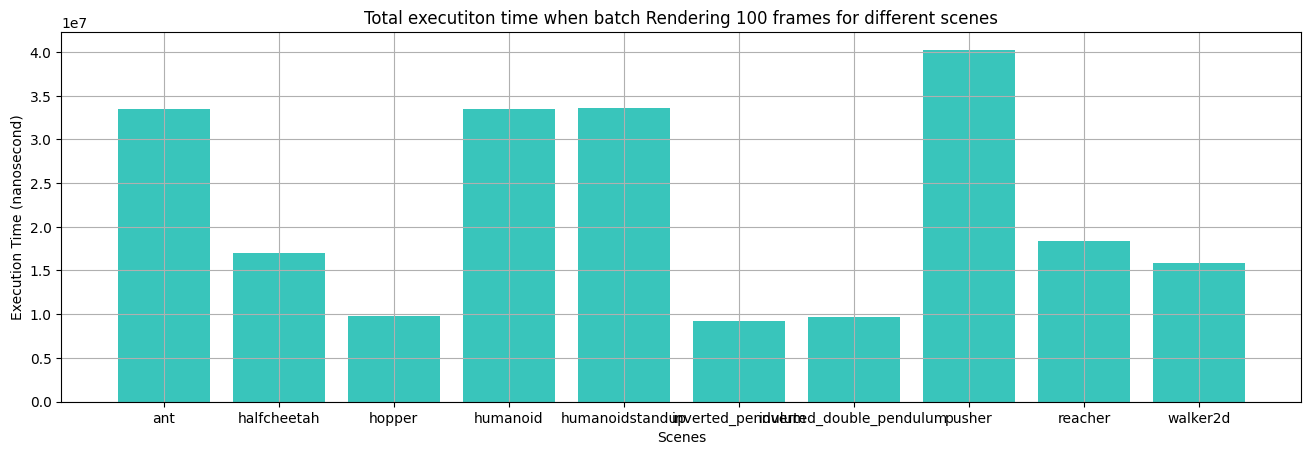

In [ ]:
plot(
    df_time[column_indices[0]],
    title="Total executiton time when batch Rendering 100 frames for different scenes",
    ylabel="Execution Time (nanosecond)",
    xlabel="Scenes"
)

,max fps
ant,2986.018565
halfcheetah,5880.141662
hopper,10184.901800
humanoid,2988.452827
humanoidstandup,2980.253466
inverted_pendulum,10839.678339
inverted_double_pendulum,10287.289005
pusher,2483.075358
reacher,5453.595141
walker2d,6313.888262


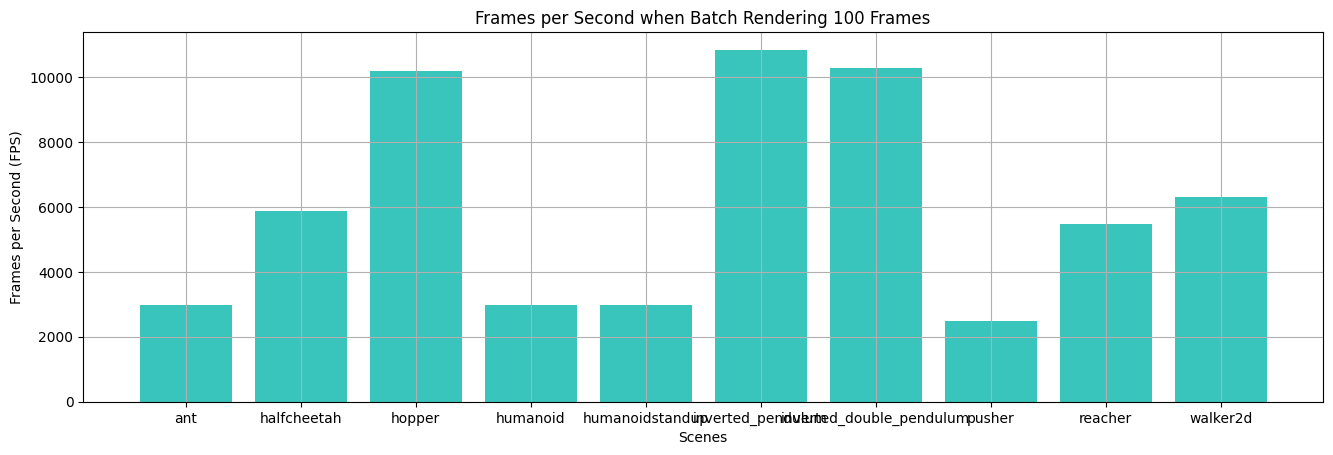

In [ ]:
df_fps = pd.DataFrame(1 / (num_frames_timings[:, :1] / 10**9 / target_batch_size), index=row_indices, columns=("max fps", ))
display(df_fps)

plot(
    df_fps['max fps'],
    title="Frames per Second when Batch Rendering 100 Frames",
    ylabel="Frames per Second (FPS)",
    xlabel="Scenes",
)

In [ ]:
#@title # Terminating Colab Automatically
try:
  from google.colab import runtime
  print("Terminating Colab")
  runtime.unassign()
except ModuleNotFoundError:
  print("Not in Colab, skip termination")